<a href="https://colab.research.google.com/github/Jagadishchandra17/classification-of-Waste-Products-using-Transfer-Learning/blob/main/Classification_of_Waste_Products_Using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Classification of Waste Products Using Transfer Learning**

##Overview


EcoClean faces a significant challenge in efficiently and accurately sorting waste. The current manual sorting process is labor-intensive and susceptible to errors, often leading to contamination of recyclable materials. To address this issue, this project leverages machine learning and computer vision to automate waste classification. By utilizing transfer learning with a pre-trained VGG16 model, the goal is to develop a scalable and efficient solution that enhances waste sorting accuracy while reducing manual effort.

##Objective
The primary objective of this project is to develop an automated waste classification model capable of distinguishing between recyclable and organic waste based on image inputs. Through transfer learning, the model will be trained, fine-tuned, and evaluated to ensure high classification accuracy. This solution aims to support real-world waste management efforts by improving sorting efficiency and minimizing contamination rates.

##Final Deliverable
 A trained deep learning model that classifies waste images into recyclable and organic categories with high accuracy.

## Importing Required Libraries

In [ ]:
import numpy as np
import os
# import random, shutil
import glob


from matplotlib import pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread

# from os import makedirs,listdir
# from shutil import copyfile
# from random import seed
# from random import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import InceptionV3
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


**Transfer learning** is a powerful technique in deep learning that enables the use of pre-trained models to solve related tasks efficiently. It involves retaining the early layers of a pre-trained network while re-training the later layers on a specific dataset. This approach allows the model to leverage previously learned features, enhancing its performance on the new classification task.

A typical transfer learning workflow in Keras follows these steps:

Initialize the base model and load pre-trained weights (e.g., ImageNet).

Freeze the base model's layers by setting training = False, ensuring that earlier features remain unchanged.

Define a new model that builds on top of the base model’s output.

Train the final model using the specific dataset, optimizing it for the classification task.

## Building a Model to Classify Recyclable and Organic Waste
Dataset
For this project, we will use the Waste Classification Dataset.You will be using the [Waste Classification Dataset](https://www.kaggle.com/datasets/techsash/waste-classification-data?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01).
 This dataset consists of labeled images of waste items categorized as either recyclable (1) or organic (0). The goal is to train a deep learning model that can accurately classify new waste images based on these categories.

## Importing Data
To prepare the dataset for training, we will create a directory structure named o-vs-r-split within the environment. This will facilitate the organization of training and validation data, ensuring an efficient workflow for model development.

In [ ]:
import requests
import zipfile
from tqdm import tqdm

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
file_name = "o-vs-r-split-reduced-1200.zip"

print("Downloading file")
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)


def extract_file_with_progress(file_name):
    print("Extracting file with progress")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        members = zip_ref.infolist()
        with tqdm(total=len(members), unit='file') as progress_bar:
            for member in members:
                zip_ref.extract(member)
                progress_bar.update(1)
    print("Finished extracting file")


extract_file_with_progress(file_name)

print("Finished extracting file")
os.remove(file_name)

Extracting file with progress


100%|██████████| 1207/1207 [00:00<00:00, 5413.44file/s]

Finished extracting file
Finished extracting file


###Defining Configurations

In [ ]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R']
seed = 42

##Loading Images using ImageGeneratorClass

Transfer learning works best when models are trained on smaller datasets.

The folder structure looks as follows:

```python
o-vs-r-split/
└── train
    ├── O
    └── R
└── test
    ├── O
    └── R
```


###ImageDataGenerators


Now you will create ImageDataGenerators used for training, validation and testing.

Image data generators create batches of tensor image data with real-time data augmentation. The generators loop over the data in batches and are useful in feeding data to the training process.


In [ ]:
# Create ImageDataGenerators for training and validation and testing
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)

Found 800 images belonging to 2 classes.


In [ ]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

Found 200 images belonging to 2 classes.


## Creating a Test_generator and using the test_datagen object

In this task, we will create a test_generator using the test_datagen object to efficiently load and preprocess the test dataset. The test_datagen instance of ImageDataGenerator ensures that test images undergo the same preprocessing steps as the training data, maintaining consistency in model evaluation. Using a generator allows us to load images in batches rather than all at once, which optimizes memory usage and computational efficiency. This approach is particularly useful when handling large datasets, as it prevents excessive memory consumption. Additionally, by setting specific parameters, we ensure that the test data is processed correctly for accurate model evaluation.

The test_generator is configured with parameters that define how the test images are handled. Setting class_mode='binary' ensures that the model performs binary classification, distinguishing between recyclable and organic waste. The shuffle=False parameter maintains the order of test images, which is essential for accurate result interpretation. Defining target_size=(img_rows, img_cols) ensures that all test images are resized to match the input requirements of the trained model. By using test_generator, we can systematically evaluate the model’s performance on unseen data, ensuring its accuracy before deployment in real-world waste classification applications.










In [ ]:
test_generator = test_datagen.flow_from_directory(
    directory=path_test,
    class_mode='binary',
    seed=seed,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)


Found 200 images belonging to 2 classes.


In [ ]:
print(len(train_generator))

25


Labels: [np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O')]


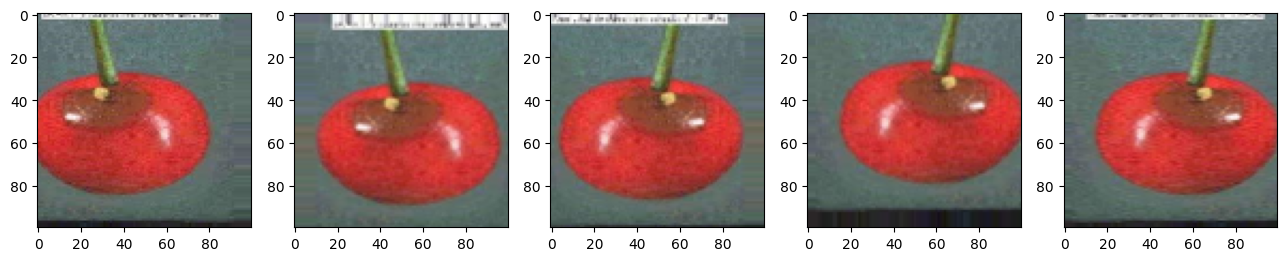

In [ ]:
##Let's look at a few augmented images:

from pathlib import Path

IMG_DIM = (100, 100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_files = train_files[:20]
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]


**Pre-trained models** are neural networks that have been trained on large datasets and are widely used for image classification tasks. They serve as the foundation for transfer learning, allowing models to leverage learned features instead of training from scratch. **VGG16** is one such pre-trained model known for its deep architecture and strong performance in image recognition tasks. By loading VGG16, we can either use it directly or fine-tune it to classify waste images into recyclable and organic categories.

In [ ]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


We flatten the output of a vgg model and assign it to the model `output`, we then use a Model object `basemodel` to group the layers into an object for training and inference .
With the following inputs and outputs

inputs: `vgg.input`

outputs: `tf.keras.layers.Flatten()(output)`


In [ ]:
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

In [ ]:
## Next, we freeze the basemodel
for layer in basemodel.layers:
    layer.trainable = False

To enhance the model’s performance and prevent overfitting, we will add a Dropout layer for regularization. This new layer will be placed on top of the base model while keeping the lower layers unchanged. To preserve the pre-trained features, we will set training=False when calling the base model, ensuring that only the newly added layers are updated during training. This approach allows the model to leverage the powerful feature extraction capabilities of VGG16 while adapting to the specific task of waste classification.

In [ ]:
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional (Functional)              │ (None, 8192)                │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Compiling the Model

In [ ]:
for layer in basemodel.layers:
    layer.trainable = False


from tensorflow.keras import optimizers

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

In [ ]:
## we will be using early stopping to avoid over training the model

from tensorflow.keras.callbacks import LearningRateScheduler


checkpoint_path='O_R_tlearn_vgg16.keras'

# define step decay function
class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss',
                    patience = 4,
                    mode = 'min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

In [ ]:
extract_feat_model = model.fit(train_generator,
                               steps_per_epoch=5,
                               epochs=10,
                               callbacks = callbacks_list_,
                               validation_data=val_generator,
                               validation_steps=val_generator.samples // batch_size,
                               verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8560 - loss: 0.3571lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 93s 20s/step - accuracy: 0.8582 - loss: 0.3541 - val_accuracy: 0.7656 - val_loss: 0.4439 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7658 - loss: 0.5156lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 141s 33s/step - accuracy: 0.7694 - loss: 0.5113 - val_accuracy: 0.8333 - val_loss: 0.3335 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8603 - loss: 0.3700lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 90s 20s/step - accuracy: 0.8648 - loss: 0.3609 - val_accuracy: 0.8490 - val_loss: 0.3225 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7775 - loss: 0.3901lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 141s 33s/step - accuracy: 0.7802 - loss: 0.3924 - val_accuracy: 0.8906 - val_loss: 0.3035 - learning_rate: 7.4082e-05
Epoch 

##Plot loss curves for training and validation sets (extract_feat_model)

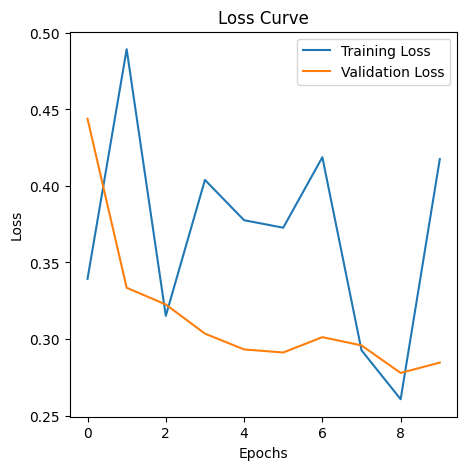

In [ ]:
import matplotlib.pyplot as plt

history = extract_feat_model

# plot loss curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

This loss curve reveals overfitting, as the training loss continues to decrease while the validation loss plateaus and slightly increases. The diverging trends between training and validation loss indicate the model is memorizing training data rather than generalizing. The initial sharp drop in both losses shows rapid initial learning. The fluctuations in training loss suggest possible instability or a high learning rate. The gap widening between the two losses reinforces the overfitting diagnosis.

##Plot accuracy curves for training and validation sets (extract_feat_model)

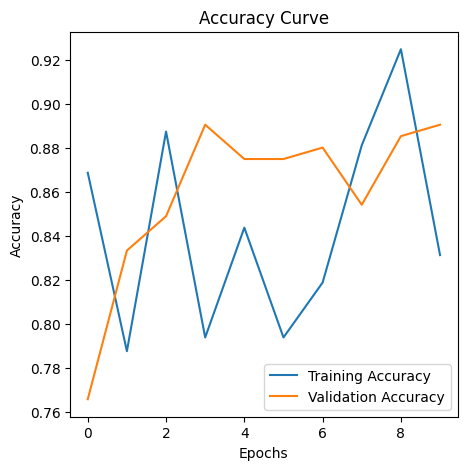

In [ ]:
import matplotlib.pyplot as plt

history = extract_feat_model

# Plotting the accuracy curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


the training accuracy rises rapidly, while the validation accuracy sees a slower, more gradual increase.  However, the training accuracy exhibits significant fluctuations throughout training, indicating potential instability in the learning process.  More importantly, the validation accuracy plateaus and even shows signs of decreasing in later epochs, suggesting the model is no longer effectively generalizing to unseen data. while the model excels at fitting the training set, its ability to generalize suffers, indicating a need for adjustments to mitigate overfitting

## Finetuning the model


Fine-tuning is an optional step in transfer learning, it usually ends up improving the performance of the model.

You will **unfreeze** one layer from the base model and train the model again.

In [ ]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

for layer in basemodel.layers:
    layer.trainable = False

display([layer.name for layer in basemodel.layers])

set_trainable = False

for layer in basemodel.layers:
    if layer.name in ['block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in basemodel.layers:
    print(f"{layer.name}: {layer.trainable}")

['input_layer_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten_1']

input_layer_2: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: True
block5_pool: True
flatten_1: True


In [ ]:
## Similar to what we did before, you will create a new model on top, and add a Dropout layer for regularization.


model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

checkpoint_path='O_R_tlearn_fine_tune_vgg16.keras'

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss',
                    patience = 4,
                    mode = 'min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

fine_tune_model = model.fit(train_generator,
                    steps_per_epoch=5,
                    epochs=10,
                    callbacks = callbacks_list_,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // batch_size,
                    verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5707 - loss: 0.7377lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 95s 21s/step - accuracy: 0.5714 - loss: 0.7354 - val_accuracy: 0.8073 - val_loss: 0.5615 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6552 - loss: 0.6067lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 92s 21s/step - accuracy: 0.6606 - loss: 0.6025 - val_accuracy: 0.6615 - val_loss: 0.5761 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6897 - loss: 0.5924lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 143s 34s/step - accuracy: 0.6924 - loss: 0.5892 - val_accuracy: 0.8385 - val_loss: 0.4218 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7999 - loss: 0.4017lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 141s 33s/step - accuracy: 0.7989 - loss: 0.4051 - val_accuracy: 0.8438 - val_loss: 0.3795 - learning_rate: 7.4082e-05
Epoch 

##Plot loss curves for training and validation sets (fine tune model)

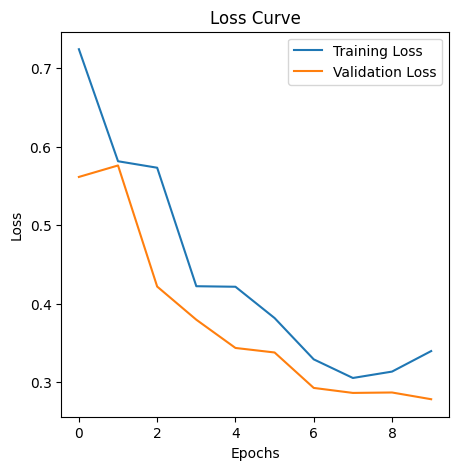

In [ ]:
history = fine_tune_model


plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


This loss curve presents a significantly improved scenario compared to the previous one. While the earlier curve exhibited clear signs of overfitting with a widening gap between training and validation loss, this new curve demonstrates a much closer convergence between the two, indicating improved generalization. The previous curve also showed significant fluctuations in training loss, suggesting instability in the learning process. In contrast, this new curve exhibits a much smoother, more stable learning process. Moreover, the previous curve's validation loss plateaued, suggesting no further improvement. This new curve, however, shows a continued decrease in both training and validation loss, suggesting potential for further optimization. In essence, these changes likely reflect successful adjustments to the model or training process, resulting in a more stable, better-generalizing model with reduced overfitting

## Plot accuracy curves for training and validation sets  (fine tune model)

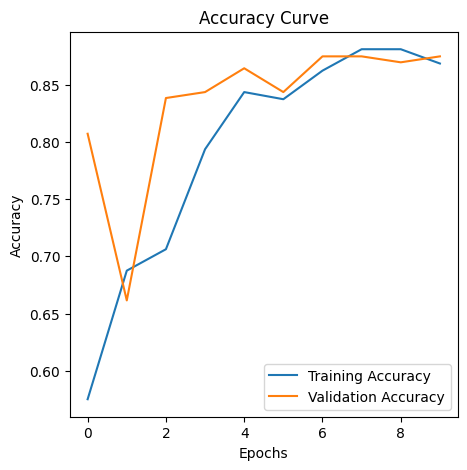

In [ ]:
history = fine_tune_model

# Plotting the accuracy curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

This accuracy curve presents a significant improvement over the previous one. While the earlier curve demonstrated clear overfitting with a widening gap between training and validation accuracy, this curve shows a much closer convergence, indicating improved generalization. The previous curve also exhibited significant fluctuations in training accuracy, suggesting instability. In contrast, this curve shows a much smoother, more stable training process. Additionally, this curve plateaus at a higher accuracy compared to the previous one, indicating a better-performing model. Furthermore, this curve shows a more rapid initial improvement in both training and validation accuracy compared to the previous one. Overall, this new accuracy curve reflects a successful adjustment to the model or training process, resulting in a more stable, better-generalizing, and higher-performing model with reduced overfitting.

## Evaluating both models on test data

In [ ]:
from pathlib import Path

# Load saved models
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

# Load test images
test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O[:50] + test_files_R[:50]

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

# Make predictions for both models
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

# Convert predictions to class labels
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

# Print classification report for both models
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))


Extract Features Model
              precision    recall  f1-score   support

           O       0.89      0.94      0.91        50
           R       0.94      0.88      0.91        50

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.84      0.94      0.89        50
           R       0.93      0.82      0.87        50

    accuracy                           0.88       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.88      0.88       100



The Extract Features Model demonstrates superior performance across all metrics, achieving an accuracy of 0.91 compared to the Fine-Tuned Model's 0.88.  Specifically, the Extract Features Model exhibits higher precision for class 'R' (0.94 vs 0.93) and higher recall for class '0' (0.94 vs 0.84). The F1-scores for both classes in the Extract Features Model are also higher, indicating a better balance between precision and recall.  Overall, the Fine-Tuned Model shows a decrease in performance, suggesting that the fine-tuning process may have negatively impacted the model's ability to generalize.  Therefore, the Extract Features Model proves to be more effective in this comparison.

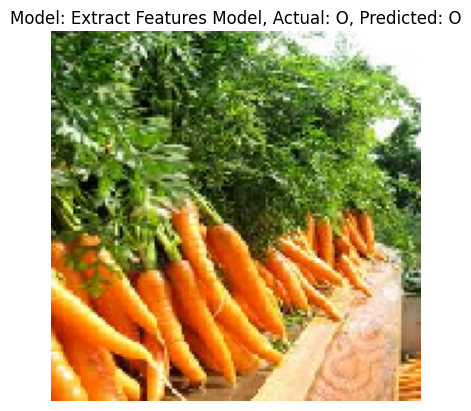

In [ ]:
# Plot one of the images with actual label and predicted label as title
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Specify index of image to plot, for example index 0
index_to_plot = 0
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )

## Plot a test image using Extract Features Model (index_to_plot = 1)

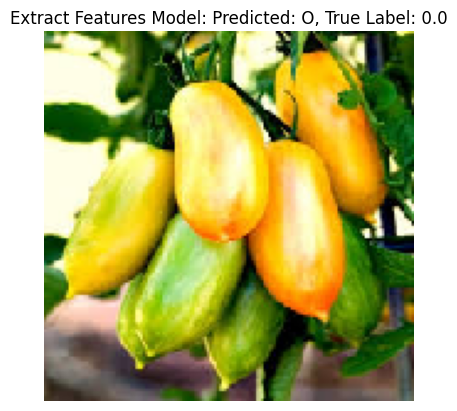

In [ ]:
def plot_image_with_title(image, label, model_name, predicted_label):
    plt.imshow(image)
    plt.title(f'{model_name}: Predicted: {predicted_label}, True Label: {label}')
    plt.axis('off')
    plt.show()

# Assume you have the necessary variables defined:
index_to_plot = 1
model_name = 'Extract Features Model'

# Get the test image and predicted label
test_image = test_generator[index_to_plot][0][0]  # Grab the image from the generator
true_label = test_generator[index_to_plot][1][0]  # Get the true label for comparison

# Get the predicted label (assuming the prediction logic has already been done)
predicted_label = predictions_extract_feat_model[index_to_plot]  # Use the predictions from the Extract Features model

# Call the function to plot the image with the prediction
plot_image_with_title(test_image, true_label, model_name, predicted_label)
